# Black Garlic: Calibrating PI Temperature Control

<img src="setup.jpg",width=600,height=400>

### Measuring heat capacity and cooling rate with an Arduino to tune controller gains

The goal of this project is to build a simple circuit and PI controller to track a temperature set point using a crock pot. The sensing and control is done with Arduino, but in order to measure the system properties and intuitively design a control law, we'll use Python to run an experiment on our system and analyze the data.

__Caveat__: I'm not a control theorist or a professional engineer. This was just a hobby project to learn about PI control, and although I hope it's helpful to anyone wanting to build something similar or learn about systems and control, I might have done some things wrong (or at least stupidly). On the other hand, if you actually know what you're doing and you notice some such things, please feel free to let me know.

__Safety Note:__ The crock pot hooks up to line voltage here, which gets switched on and off with a relay. As always, be careful when working with line voltage and it's a good idea to have some kind of failsafe (my relay has a positive-temperature resistor built in as a sort of fuse) and have someone who knows what they're doing look at it before you turn it on.

### Part 1: The Circuit


<img src="materials.jpg",width=600,height=400>

The electonic part of the project is actually really simple. We have a heater (in my case a crock pot) with some maximum power output (Let's call it $P_\text{max}$, in watts) and we can control the power output by modulating the percentage of the duty cycle $u$. That is, $ P = uP_\text{max}. $ 

So the circuit will have three components: a thermistor to measure temperature ([Adafruit](https://learn.adafruit.com/thermistor/using-a-thermistor) has a helpful writeup on using the B-value formula), a relay (I used an Omron G3MB-202P solid-state relay) to switch the current to the crock pot, and the Arduino to coordinate everything. We'll have the thermistor on a voltage divider read by the analog input to the Arduino, and the relay controlled by the digital output. 

<img src="schematic.png",width=600,height=400>

### Part 2: The Controller

I'm choosing PI control for this project, since it's reliable and straightforward to implement. [Control Guru](http://controlguru.com/) has a great background explanation of PI control and a different method of tuning the controller. So for this temperature controller we'll have some set point (reference) temperature $r,$ and a measured crock pot temperature $T.$ We'll use feedback to choose the duty cycle $u$ based on the error $\epsilon = T-r$ between the reference and the measurement with the PI control law $$u = -K_P\epsilon + K_I\int_0^t \epsilon \, dt, $$ where we'll decide what to use for the proportional and integral gains $K_P$ and $K_I$ in a minute.

### Part 3: Controller Design

<img src="block_diagram.png",width=600,height=400>

There are plenty of resources for tuning controller gains empirically, but for this system the physics is simple enough that we can manipulate things a little and end up being able to choose controller gains based on easily measured physical properties and one relatively intuitive free parameter. __Note__: this will be a little more math-heavy than the other parts, so feel free to skip to the end results. For a much deeper (and better) explanation of controller design based on system dynamics, check out Steve Brunton's [Controls Bootcamp](https://www.youtube.com/watch?v=Pi7l8mMjYVE&list=PLMrJAkhIeNNR20Mz-VpzgfQs5zrYi085m).

The first thing we'll need to establish the system dynamics is Newton's law of cooling, which says that if an object is at a temperature $T$ in an environment at some room temperature $T_R$, its rate of temperature change $\dot{T}$ is proportional to the temperature difference. In other words, $$ \dot{T} = -\alpha(T-T_R), $$ where $\alpha$ is the _cooling rate_. Since our input to the system is in the form of heat energy, we also need to know how much the temperature will change due to some heat input. This relationship is the _heat capacity_ $C$ of the system, so for some heat input $Q$, the temperature will change by $$\Delta T = Q/C.$$

What we actually control, however, is the power input $P$, which is the _rate_ of heat input. Note that this ignores things like residual heat in the heating element when the power is cut off, heterogeneities in the temperature within the system, etc, but here we'll just assume that's all negligible. If that assumption turns out to be wrong, it should show up in the data. Combining all of this, we get the differential equation that governs the temperature of the system: $$\dot{T} = \frac{P}{C} - \alpha T $$

For convenience, I changed variables so that the temperature is relative to the room temperature, i.e. $T = T_\text{actual} - T_\text{room}. $ Again, our input to the system is the power $P$, so we want to see if we can come up with a way to choose the PI gains based on the heat capacity and cooling rate of the system, which we'll be able to measure.

Following the notation in the block diagram above, the frequency domain representation of this differential equation is the plant transfer function $G(s)$ and we will have to choose our controller transfer function $K(s)$. If we specify the desired behavior of the _loop_ transfer function $L(s)=K(s)G(s)$ we can invert the plant dynamics and solve for $K(s)$.

So the Laplace transform of the dynamical system is $$ s\bar{T} = -\alpha\bar{T} + \frac{\bar{P}}{C} $$

Solving for the plant transfer function $G(s)= \bar{T}/\bar{P}$, $$ G(s) = \frac{1}{C(s + \alpha)}. $$

Then we can specify the form we would like the loop transfer function to take. Generally, we would like large responses to low frequencies (which we'll assume are set point changes or system disturbances) and suppression of high frequencies, so $L = \omega_B/s,$ where $\omega_B$ is the bandwidth frequency. This is a free parameter we can choose, so the control loop will be most responsive to frequencies below $\omega_B.$ Practically, it could also be tweaked to tune things like response time vs. overshoot.

So then $L(s) = K(s)G(s) = \omega_B/s$ and we can solve for the controller transfer function: $$K(s) = \omega_B C + \frac{\omega_B C \alpha }{s} $$ This transfer function corresponds to a PI controller with proportional gain $K_P = \omega_B C$ and integral gain $K_P\alpha$. Finally, we have to convert the desired power input $P$ into a duty cycle $u$: $P = uP_\text{max}$

So by measuring the heat capacity $C$ and cooling rate $\alpha$ and specifying the bandwidth frequency, we choose the controller gains. There is still some tuning to do, in terms of $\omega_B$, but hopefully if we find a bandwidth frequency that works for our application on one heating system, implementing the controller on another system will just be a matter of re-measuring the heat capacity and cooling rate.

### Part 4: The Experiment

Now we have a PI control law in terms of measurable properties of the system. How can we measure the heat capacity and cooling rate? Consider the dynamical equation $\dot{T} = \frac{P}{C} - \alpha T$ in the case where we apply a constant power for a long period of time and then turn it off. From the differential equation, in the heating phase we can expect the temperature to behave like $$T - T_R = (T_\text{ss} - T_R)(1-e^{-\alpha t}),$$ where now the temperature is shifted back to the measured temperature. In other words, it should ramp up to some steady-state temperature $T_\text{ss}.$ If we shut off the power and the system is at a temperature $T_0,$ then $u=0$ and we should see a simple exponential decay: $$ T-T_R = T_0e^{-\alpha t}. $$

The exponential decay gives us $\alpha,$ and we can get the heat capacity from the final temperature of the heating process by considering that when the system reaches that temperature, the rate of temperature chance $\dot{T}$ is zero, so that $\frac{P}{C} -\alpha (T_\text{ss}-T_\text{room}) = 0,$ or $C = \frac{\alpha (T_\text{ss}-T_\text{room})}{P}.$

__Note:__ As another control strategy we could rearrange this result to get $$ P = \frac{\alpha}{C} (T_\text{ref} -T_\text{room}) $$ and do _open-loop_ control for the reference temperature $T_\text{ref}$. I haven't tried this, but it would be very simple to implement.

So that's the plan. First, define the parameters for the experiment (heater wattage, measurement frequency, collection times, etc.) and some functions to help with serial communication with the Arduino...

In [2]:
import serial
import time
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

dt = 10               # Delay time between Arduino measurements in seconds. Also duty cycle width
P_max = 35            # Crock pot wattage
U = 100               # Duty cycle for warmup stage
on_time = 45*60       # Total heater on time in seconds
off_time = 120*60     # Total heater off time in seconds


def read_from(ser):
    """ If there is data from Serial, reformat to ASCII and return it """
    if ser.in_waiting:
        try:
            return ser.readline().decode("ascii").strip()
        except serial.SerialException:
            # Needs to reset serial sometimes? On my Ubuntu anyway, shouldn't have to have this though
            return None
    else: return None
    
def write_to(ser, data):
    """ Convert to binary and write to Serial """
    ser.write(bytes(str(data), 'ascii') + b'\r\n')
    
def duration_read(ser, run_time):
    """ Read from Serial for specified amount of time. Return numpy array of data"""
    t0 = time.time()
    data = []
    while(time.time()-t0 < run_time):
        ser_out = read_from(ser)
        if ser_out:
            data.append(float(ser_out))
    return np.array(data)

So to run the experiment, I'll use a sketch that's a little more complicated than the final PI controller. This will take the duty cycle as input from the serial port, and report the temperature readings back to Python.

```C++
#include <math.h>

#define SERIES_RESISTOR 7000     // 7k resistor in series
#define THERMISTOR_PIN A0        // Thermistor between A0 and GND
#define RELAY_PIN 2              // output pin for relay

// Values for B-Value temperature conversion
#define T0 298.15          // Nominal temperature for B-value equation (in Kelvin)
#define R0 10000                  // Nominal thermistor resistance
#define B 3428                  // From 25-80 C range for Murata NCP15XH103F03RC

int delayTime;                    // Time between readings in ms. Also duty cycle width
float dutyCycle = 0;                // percentage of delayTime spent with relay ON (controlled by Serial)
float T;                          // Temperature in Celsius, calcuated from the voltage across the thermistor

void setup() {
  Serial.begin(9600);                      // Set up the serial for debugging output
  pinMode(RELAY_PIN, OUTPUT);
  Serial.println("Ready");                 // Message for Python script
  while(Serial.available() == 0){}         // Wait for response from serial
  delayTime = Serial.parseInt()*1000;      // Read delay time in seconds  
}

void loop() {
  // Go through a duty cycle of the relay: ON for dutyCycle % of dt, then off for the rest of dt
  digitalWrite(RELAY_PIN, HIGH);
  delay(delayTime*dutyCycle);
  digitalWrite(RELAY_PIN, LOW);
  delay(delayTime*(1-dutyCycle) );
    
  T = tempConvert(analogRead(THERMISTOR_PIN));               // Read the voltage across the thermesistor
  Serial.println(T);
  Serial.println(dutyCycle);
}

void serialEvent(){
  dutyCycle = (float) Serial.parseInt()/100;     // Read instructions from Serial
  while(Serial.available()){
    Serial.read();
  }
}

float tempConvert(int count){
  float R = SERIES_RESISTOR  / ((float) 1023/count - 1); // Convert to resistance across thermistor
  return 1 / ( (1/T0) + (1/B)*log(R/R0) ) - 273.15;  // B-value equation
}
```

Upload code to Arduino and wait for the Arduino to initialize

In [22]:
arduino = serial.Serial('/dev/ttyUSB0', 9600)  # Change to name of your USB port

# Wait for Arduino to initialize
ser_out = 'Waiting'
while ser_out != "Ready":
    if arduino.in_waiting:
        ser_out = read_from(arduino)  # Arduino prints "Ready" in initialization

print("Arduino initialized")

Arduino initialized


Now turn on the crock pot. For the previously specified "on" time, the Arduino reports the temperature at an interval of dt. Then the crock pot shuts off and the process repeats for the "off" time we set earlier. At the end, save the temperature data to a text file (so we don't have to redo this).

In [35]:
# Send desired collection frequency (in seconds). Arduino will immediately begin collecting data
write_to(arduino, dt)

# Turn on the crock pot and read data
print("Turning on relay...")
write_to(arduino, U)
T_on = duration_read(arduino, on_time)  # Read from Serial

# Save results to text file
t_on = np.arange(0, len(T_on))*(dt/60)
on_data = np.transpose(np.vstack((t_on, np.array(T_on))))
np.savetxt('warmup_temps.dat', on_data, fmt='%.2f', header='Time(s)\tTemp(deg C)', delimiter='\t')

# Turn off the crock pot and restart the timer
print("Turning off relay...")
write_to(arduino, 0)  # Turn off relay

T_off = duration_read(arduino, on_time)  # Read from Serial

# Save results to text file
t_off = np.arange(0, len(T_off))*(dt/60)
off_data = np.transpose(np.vstack((t_off, np.array(T_off))))
np.savetxt('cooldown_temps.dat', off_data, fmt='%.2f', header='Time(s)\tTemp(deg C)', delimiter='\t')

print("Done")

Turning on relay...
Turning off relay...
Done


Now we want to use our models for heating and cooling behavior to fit the recorded data and extract $\alpha$ and $C$. You could do this with linear fitting and log temperature, but it's easy enough to just use SciPy's curve_fit function:

Cooldown fit:
Room Temp: 24.64 C
Initial Temp: 55.75 C
Cooling Rate: 0.000242 C/sec
[  8.43360457e-02   3.14890554e-02   8.43144192e-05]
Steady State Temp: 79.96 C
Cooling Rate: 0.000295 C/sec
[  6.84078099e-01   2.93080771e-04]
Heat Capacity: 3574.81 J/K


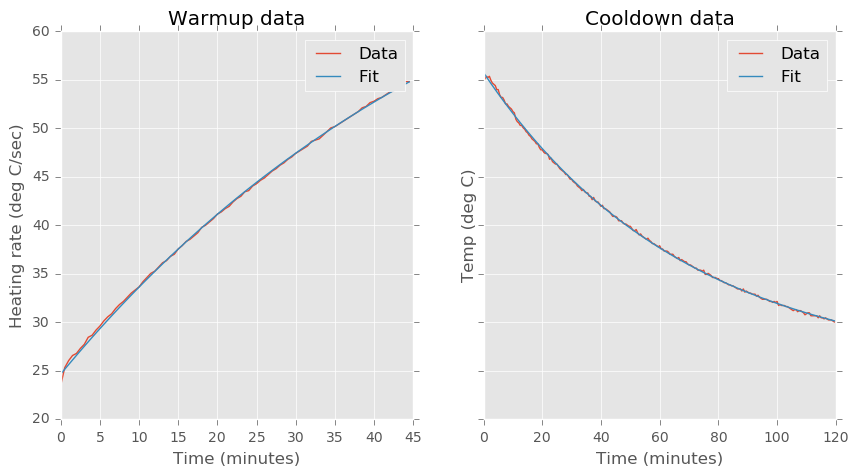

In [6]:
from scipy.optimize import curve_fit

# Load data from text files
on_data = np.loadtxt('warmup_temps.dat', delimiter='\t')
t_on = on_data[:, 0]
T_on = on_data[:, 1]

off_data = np.loadtxt('cooldown_temps.dat', delimiter='\t')
t_off = off_data[:, 0]
T_off = off_data[:, 1]

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

# Recall that times are in minutes (helps with calculating exponents)
#    Could also do this with linear fit of log temp, but this is nicer for getting T0 and T_room
cooldown_model = lambda t, T_room, T0, alpha: T_room + (T0-T_room)*np.exp(-alpha*t)
popt, pcov = curve_fit(cooldown_model, t_off, T_off)
T_room, T0, alpha = popt

print("Cooldown fit:")
print("Room Temp: {0:0.2f} C".format(T_room))
print("Initial Temp: {0:0.2f} C".format(T0))
print("Cooling Rate: {0:0.6f} C/sec".format(alpha/60))    # Convert to cooling rate in C/sec
print(np.sqrt(np.diag(pcov)))   # Errors on parameter fits

ax2.plot(t_off, T_off, label='Data')
ax2.plot(t_off, cooldown_model(t_off, T_room, T0, alpha), label='Fit')
ax2.legend()

warmup_model = lambda t, T_ss, alpha: (T_ss-T_room)*(1 - np.exp(-alpha*t)) + T_room
popt, pcov = curve_fit(warmup_model, t_on, T_on)
T_ss, alpha = popt
C = U*P_max/(alpha*(T_ss-T_room))

print("Steady State Temp: {0:0.2f} C".format(T_ss))
print("Cooling Rate: {0:0.6f} C/sec".format(alpha/60))
print(np.sqrt(np.diag(pcov)))   # Errors on parameter fits
print("Heat Capacity: {0:0.2f} J/K".format(C))

ax1.plot(t_on, T_on, label='Data')
ax1. plot(t_on, warmup_model(t_on, T_ss, alpha), label='Fit')
ax1.legend()

plt.ylabel('Temp (deg C)')
ax1.set_title('Warmup data')
ax1.set_ylabel('Heating rate (deg C/sec)')
ax1.set_xlabel('Time (minutes)')
ax2.set_xlabel('Time (minutes)')
ax2.set_title('Cooldown data')
plt.show()


The fits look pretty good and the parameters seem physically reasonable. So let's say $C = 3500$ J/K and $\alpha = 2.5 \times 10^{-4} \; s^{-1}.$ Note that the heat capacity is a measure of how much heat the system requires (power x time) to raise the temperature, while the cooling rate accounts for thermal conductivity, etc, so these two really are independent parameters.

To go to the PI control law, we just need to specify a bandwidth frequency $\omega_B$. That is, the frequency above which we expect the measured signal to be dominated by noise. Below that will be disturbances to the system, room temperature changes, etc. I'll choose 10 minutes as the time scale of disturbances I care about and see how that works, so $\omega_B = (600 \; s)^{-1} $

The proportional gain is $K_P = \omega_B C$ and the integral gain is $K_I = K_P\alpha$. For a set point $r$ in degrees C, the final control law for error $\epsilon = T-r$ is $$P = -K_p\epsilon + K_I\int_0^t \epsilon \, dt, $$ where $P$ is the power input. The power input can easily be converted into a duty cycle by scaling with respect to the maximum power, i.e. $$ u = \frac{P_\text{max}-P}{P_\text{max}} $$

In [15]:
omega_B = 1/(10*60)   # bandwidth frequency in Hz.

# Results of Part 3
C = 3500
alpha = 2.5e-4

Kp = omega_B*C        # proportional gain 
Ki = Kp*alpha

print("Proportional gain: {0:0.2f}".format(Kp))
print("Integral gain: {0:0.6f}".format(Ki))

Proportional gain: 5.83
Integral gain: 0.001458


### Part 5: Set Point Tracking

So that's our controller. I'm going to make one more tweak, which will hopefully address the problem of "windup". Basically, we can only actuate the system so aggressively (100% duty cycle), and even then we know from experience it will take the crock pot a long time to come up to temperature. If the integration was running this whole time, the integral term would very likely end up being too large and we'd overshoot the set point.

To try to deal with that I'm going to just introduce a flag in the Arduino code, so that the integrated error won't start to be calculated until the temperature is within the control band. In other words, as long as the proportional term leads to a 100% duty cycle, we won't calculate the integrated error. With $K_P = 5.8$, that corresponds to an error of about 6 degrees C. This might lead to a slightly slower convergence, but should prevent overshoot. If you want quicker convergence, you could try something like twice the control band.

So how does it do? Using a sketch that's halfway between the manual control used for the experiment above and the full standalone PI controller, we can send a set point to the Arduino, have it respond using these gains for a few hours, and plot the results:

In [ ]:
T_ref = 60   # Degrees celsius
dt = 30      # Duty cycle width and measurement frequency
run_time = 180*60  # Run for three hours

arduino = serial.Serial('/dev/ttyUSB0', 9600)  # Change to name of your USB port

# Wait for Arduino to initialize
ser_out = 'Waiting'
while ser_out != "Ready":
    if arduino.in_waiting:
        ser_out = read_from(arduino)  # Arduino prints "Ready" in initialization

print("Arduino initialized")

# Send the measurement frequency/duty cycle width to the Arduino
write_to(arduino, dt)
# Input the set point to the Arduino
write_to(arduino, T_ref)

# Now we'll wait for run_time and record every time the Arduino sends a signal
temps = []
t0 = time.time()
while (time.time() < t0 + run_time):
    output = read_from(arduino)
    if output:
        temps.append(output)
        print(output)
   

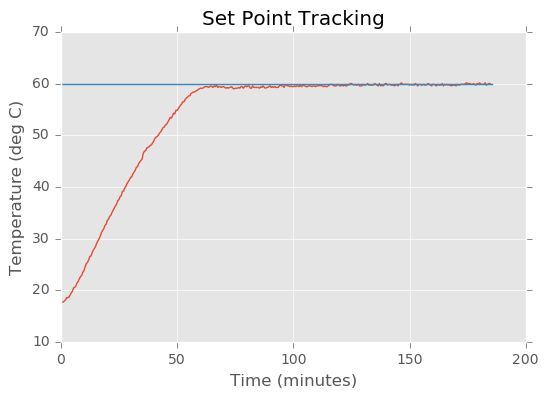

In [7]:
# Plot the results 
t = np.arange(0, len(temps))*(dt/60)
plt.plot(t, temps)
plt.plot([0, len(temps)*(dt/60)], [T_ref, T_ref])
plt.xlabel("Time (minutes)")
plt.ylabel("Temperature (deg C)")
plt.title("Set Point Tracking")
plt.show()

So that actually looks pretty good, for the purposes of making black garlic at least. I'm not sure how robust these choices of gain really are (maybe I just got lucky here), but it seems to work for this application. The next test would be to try a different crock pot and see if the same procedure produces another workable controller.

### Part 6: Standalone Control

The last step is to unplug from Python and let the Arduino do its thing. My implementation of the PI controller is below. I hardcoded the set point here, but it would be easy enough to set up a potentiometer or rotary encoder as an input knob.

```C++
#include <math.h>

#define SERIES_RESISTOR 7000     // 7k resistor in series
#define THERMISTOR_PIN A0        // Thermistor between A0 and GND
#define RELAY_PIN 2              // output pin for relay
#define P_MAX 35                 // Heater wattage

// Values for B-Value temperature conversion
#define T0 298.15          // Nominal temperature for B-value equation (in Kelvin)
#define R0 10000                  // Nominal thermistor resistance
#define B 3428.                  // From 25-80 C range for Murata NCP15XH103F03RC

// PI controller gains, calculated from slow-cooker-calibration.ipynb
#define Kp 5.8
#define Ki 1.5e-3

int delayTime = 30000;            // Time between readings in ms. Also duty cycle width
float dutyCycle = 0;              // percentage of delayTime spent with relay ON (calculated from ctrl law)
float T;                          // Temperature in Celsius, calcuated from voltage across the thermistor
int setPoint = 60;                // Target temperature for controller
float err_int = 0;                // Integrated error
boolean woundUp = false;              // "Warmup" stage of operation

void setup() {
  pinMode(RELAY_PIN, OUTPUT);
}

void loop() {
  
  // Go through a duty cycle of the relay: ON for dutyCycle % of dt, then off for the rest of dt
  digitalWrite(RELAY_PIN, HIGH);
  delay(delayTime*dutyCycle);
  digitalWrite(RELAY_PIN, LOW);
  delay(delayTime*(1-dutyCycle) );
    
  T = tempConvert(analogRead(THERMISTOR_PIN));
  if ((!woundUp) && (setPoint-T < P_MAX/Kp)){
    woundUp = true;              // System has warmed up and it's time to start integrating error
  }
  piUpdate();
}

// Update the duty cycle based on the PI control law
void piUpdate(){
   float err = setPoint-T;              // temperature error in degrees C
   if (woundUp){                          // Don't accumulate until the system winds up
     err_int += err*delayTime/1000;     // Accumulate integrated error (units are seconds)
   }
   dutyCycle = (Kp*err + Ki*err_int)/P_MAX;   // PI control law
   dutyCycle = min(1, max(0, dutyCycle));    // Restrict duty cycle to 0-100%
}

float tempConvert(int count){
  float R = SERIES_RESISTOR  / ((float) 1023/count - 1); // Convert to resistance across thermistor
  return 1 / ( (1/T0) + (1/B)*log(R/R0) ) - 273.15;  // B-value equation
}
```

And that's it! If I had time to keep working on this, I think a major improvement would be to redo the controller calculations for dimensionless error and gain (as in [this](http://controlguru.com/controller-gain-is-dimensionless-in-commercial-systems/) article). That is, error as a percentage of set point. Hope it's useful, and like I said, let me know if things are unclear or wrong.

-- Jared Callaham (sketches and notebook also on my [Github](https://github.com/jcallaham))